In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

В данном задании вам нужно будет проанализировать АБ тест, проведенный на реальных пользователях Яндекса
подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
определить характер этих изменений и практическую значимость вводимого изменения
понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)
Описание данных:

userID: уникальный идентификатор пользователя
browser: браузер, который использовал userID
slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
n_clicks: количество кликов, которые пользоваль совершил за n_queries
n_queries: количество запросов, который совершил userID, пользуясь браузером browser
n_nonclk_queries: количество запросов пользователя, в которых им не было совершено ни одного клика
Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.
Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки.


In [3]:
data=pd.read_csv('ab_browser_test.csv')

In [4]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [5]:
data.shape

(566134, 6)

In [25]:
data.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


In [26]:
clicks_exp=data[data.slot=='exp']['n_clicks'].values
clicks_ctrl=data[data.slot=='control']['n_clicks'].values

In [11]:
s1=sum(clicks_exp)

In [27]:
s2=sum(clicks_ctrl)

In [28]:
res=(s1-s2)/float(s2)*100

In [29]:
res

1.6135689824415809

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения.

V 95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы отличаются статистически значимо

V 95% доверительный интервал для разности средних не содержит ноль, похоже, средние отличаются статистически значимо

# Bootstrap

In [21]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [22]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# Интервальная оценка медианы

In [30]:
np.random.seed(0)

clicks_exp_median_scores = list(map(np.median, get_bootstrap_samples(clicks_exp, 1000)))
clicks_ctrl_median_scores = list(map(np.median, get_bootstrap_samples(clicks_ctrl, 1000)))

print ("95% confidence interval for the clicks_exp median repair time:",  stat_intervals(clicks_exp_median_scores, 0.05))
print ("95% confidence interval for the clicks_ctrl median repair time:",  stat_intervals(clicks_ctrl_median_scores, 0.05))

95% confidence interval for the clicks_exp median repair time: [ 5.  5.]
95% confidence interval for the clicks_ctrl median repair time: [ 4.  4.]


# Точечная оценка разности медиан

In [31]:
print ("difference between medians:", np.median(clicks_exp) - np.median(clicks_ctrl))

difference between medians: 1.0


# Интервальная оценка разности медиан

In [32]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(clicks_exp_median_scores, clicks_ctrl_median_scores)))

In [33]:
print ("95% confidence interval for the difference between medians",  print ("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)))

95% confidence interval for the difference between medians [-1. -1.]


In [45]:
np.random.seed(0)

exp_clicks_mean_scores = list(map(np.mean, get_bootstrap_samples(clicks_exp, 1000)))
control_clicks_mean_scores = list(map(np.mean, get_bootstrap_samples(clicks_ctrl, 1000)))

print ("95% confidence interval for the exp median:",  stat_intervals(exp_clicks_mean_scores, 0.05))
print ("95% confidence interval for the control median:",  stat_intervals(control_clicks_mean_scores, 0.05))

95% confidence interval for the exp median: [ 11.5086867   11.66089388]
95% confidence interval for the control median: [ 11.20795095  11.35742732]


In [47]:
mean_scores = zip(map(np.mean, exp_clicks_mean_scores), map(np.mean, control_clicks_mean_scores))

In [48]:
delta_mean_scores = list(map(lambda x: x[1] - x[0], mean_scores))

In [49]:
print ("95% confidence interval for the difference between medians:",  stat_intervals(delta_mean_scores, 0.05))

95% confidence interval for the difference between medians: [-0.40475697 -0.19172563]


Task 3 Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и значимым статистически. Последнее утверждение нуждается в дополнительной проверке.

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах.

     Для проверки гипотезы о равенстве средних категорически нельзя использовать t-критерий Стьюдента ни при каком размере выборки, потому что количество кликов, которые мы исследуем, больше походят на распределение Пуассона, которое сильно отличается от нормального.

     Используя центральную предельную теорему, мы можем заключить, что с ростом объема выборки любое исследуемое распределение, становится похожим на нормальное, а значит, учитывая большой объем нашей выборки, оптимальным критерием в нашей задаче будет z-критерий.

     ##Все ответы неверны

     Гипотезу о равенстве средних между двумя выборками можно проверить с помощью построения доверительного интервала для среднего объединенной выборки, потому что в силу большого объема выборки этот интервал будет очень точным, и мы сможем надежно оценить необходимый доверительный интервал

     Для проверки гипотезы о равенстве средних в данной задаче можно использовать только параметрические критерии, потому что непараметрические, как известно, с увеличением размера выборки могут давать непредсказуемые результаты в силу случайности в определении их нулевого распределения.

In [52]:
from statsmodels.stats.weightstats import *
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(clicks_exp))

Shapiro-Wilk normality test, W-statistic: 0.545878, p-value: 0.000000


//anaconda/lib/python3.5/site-packages/scipy/stats/morestats.py:1330: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


 Shapiro-Wilk test is a specific test for normality
 The null hypothesis for this test is that the data are normally distributed. The Prob < W value listed in the output is the p-value. If the chosen alpha level is 0.05 and the p-value is less than 0.05, then the null hypothesis that the data are normally distributed is rejected

Populating the interactive namespace from numpy and matplotlib


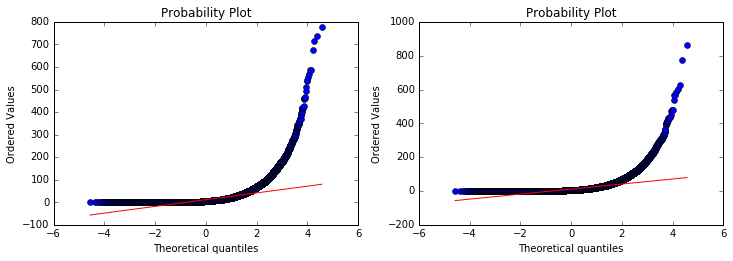

In [55]:
%pylab inline
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(clicks_exp, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(clicks_ctrl, dist="norm", plot=pylab)
pylab.show()


Проверив на нормальность. Посмотрим на распределение остатков с помощью ку-ку графика. Видим, что точки на ку-ку графике лежат довольно далеко от прямой прямой. Распределение остатков не похоже на нормальное. 

TASK 4. 
t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. 
Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных.

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных 
$$ \frac{\bar{X} - \mu}{ \sqrt {S^2 / n}}$$, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

X¯ — среднее значение в выборке — было распределено нормально $$\mathcal{N}(\mu, \frac{\sigma^2}{n})$$ 
$$\frac{n}{\sigma^2} S^2$$ — несмещенная оценка дисперсии c масштабирующим коэффициентом — была распределена по хи-квадрат c n−1 степенями свободы χ2(n−1)
Простое доказательство необходимости и достаточности этого требования можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными в рамках данного вопроса.

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого проделайте шаги ниже.

In [66]:
np.random.seed(0) #Чтобы получить такой же ответ, как у нас, зафиксируйте seed и количество псевдовыборок:
n_boot_samples = 500 #1 Получите из данных n_boot_samples псевдовыборок.

In [69]:
control_clicks_mean_scores = list(map(np.mean, get_bootstrap_samples(clicks_ctrl, n_boot_samples)))
control_boot_chi_squared = list(map(lambda x: np.std(x) ** 2, get_bootstrap_samples(clicks_ctrl, n_boot_samples)))
#2 По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)

((array([ -2.99209858e+00,  -2.71015927e+00,  -2.55162541e+00,
          -2.43921385e+00,  -2.35113311e+00,  -2.27822091e+00,
          -2.21572267e+00,  -2.16084152e+00,  -2.11178767e+00,
          -2.06734403e+00,  -2.02664403e+00,  -1.98904794e+00,
          -1.95406954e+00,  -1.92133033e+00,  -1.89052965e+00,
          -1.86142459e+00,  -1.83381593e+00,  -1.80753820e+00,
          -1.78245240e+00,  -1.75844061e+00,  -1.73540186e+00,
          -1.71324904e+00,  -1.69190643e+00,  -1.67130780e+00,
          -1.65139483e+00,  -1.63211595e+00,  -1.61342528e+00,
          -1.59528183e+00,  -1.57764883e+00,  -1.56049314e+00,
          -1.54378481e+00,  -1.52749667e+00,  -1.51160399e+00,
          -1.49608418e+00,  -1.48091659e+00,  -1.46608224e+00,
          -1.45156367e+00,  -1.43734479e+00,  -1.42341071e+00,
          -1.40974764e+00,  -1.39634279e+00,  -1.38318426e+00,
          -1.37026095e+00,  -1.35756253e+00,  -1.34507932e+00,
          -1.33280226e+00,  -1.32072287e+00,  -1.308833

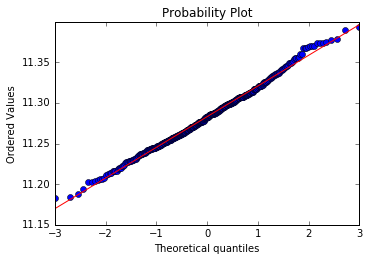

In [70]:
#3. Для получившегося вектора средних значений из n_boot_samples постройте q-q plot 
#с помощью scipy.stats.probplot для нормального распределения
pylab.figure(figsize=(12,8))
pylab.subplot(2,2,1)
stats.probplot(control_clicks_mean_scores, dist="norm", plot=pylab)

In [62]:
n = len(clicks_ctrl)

((array([ 282301.08823052,  282512.70968151,  282631.75042717,
          282716.17888969,  282782.3450597 ,  282837.12445286,
          282884.08540284,  282925.32718789,  282962.19330369,
          282995.59740261,  283026.19007273,  283054.45161344,
          283080.74708391,  283105.36069051,  283128.51819018,
          283150.40200679,  283171.16173792,  283190.92164617,
          283209.78611976,  283227.84373074,  283245.17030322,
          283261.83126848,  283277.88349787,  283293.37674667,
          283308.35480452,  283322.85642111,  283336.91605832,
          283350.56450624,  283363.82939197,  283376.73560265,
          283389.30563983,  283401.55991797,  283413.51701739,
          283425.19389989,  283436.60609342,  283447.76785089,
          283458.69228763,  283469.39150054,  283479.87667212,
          283490.1581613 ,  283500.24558336,  283510.1478802 ,
          283519.87338258,  283529.42986513,  283538.82459547,
          283548.06437779,  283557.15559197,  283566.10

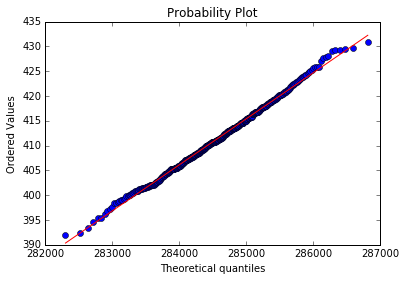

In [63]:
#4 Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot с помощью scipy.stats.probplot
#для хи-квадрат распределения с помощью команды
#Где sparams=(n-1) означают число степеней свободы = длине выборки - 1.
scipy.stats.probplot(control_boot_chi_squared, dist="chi2", 
                     sparams=(n-1), plot=plt)

Почему мы проверяем именно такие условия?

В исходной постановке t-критерий требует нормальности распределения Xi. Именно из-за этого предположения мы имеем, что
$$ \sum_i X_i  \sim  \mathcal{N}(n \mu, n\sigma^2 )$$
в силу линейности матожидания, независимости всех Xi между собой и того факта, что сумма нескольких нормальных случайных величин также нормальна.

Поэтому, пользуясь опять формальными свойствами матожидания и дисперсии можем записать, что 

$$\frac{1}{n} \sum_i X_i  - \mu ~\sim~ \mathcal{N}(0,  \frac{\sigma^2}{n} )$$

Заметим теперь, что следующие распределения эквивалентны $$\mathcal{N} (0, \frac{\sigma^2}{n}) \sim \sqrt{\frac{\sigma^2}{n}} \mathcal{N}(0, 1)$$
То есть другими словами мы получили, что исходная статистика $$\frac{\bar{X} - \mu}{ \sqrt {S^2 / n}}$$ распределена как $$\frac{ \mathcal{N}(0, 1) } { \sqrt {  \frac{S^2n} { n  \sigma^2} } }   ~\sim~  \frac{ \mathcal{N}(0, 1) } { \sqrt { \frac{S^2} { \sigma^2} } }$$
Вспомним, что распределение Стьюдента с n−1 степенями свободы определяется как $$\frac{ \mathcal{N}(0, 1) } { \sqrt { \chi^2 / (n-1)  } }$$. Поэтому и требования, которые накладываются, имеют вид, указанный в начале этого вопроса.

Полезно, однако, заметить, что можно подставить в числитель и знаменатель любые случайные величины, распределенные по нормальному закону и по Хи-квадрат соответственно, для этого необязательно, чтобы именно Xi были распределены нормально. Поэтому, если мы убедимся в том, что, действительно, числитель и знаменатель распределены образом, указанным выше, то можно смело использовать t-критерий Стьюдента.

In [ ]:

v R2 для выборочного среднего получился больше, чем 0.99

v R2 для выборочной суммы квадратов отклонения от выборочной суммы получился больше, чем 0.99

TASK 5. 
Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [73]:
mean_user_clicks_exp = data[data.slot == 'exp'].groupby('userID').aggregate(np.sum).n_clicks.tolist()

In [74]:
mean_user_clicks_ctrl = data[data.slot == 'control'].groupby('userID').aggregate(np.sum).n_clicks.tolist()


Ранговый критерий Манна-Уитни
$$H_0\colon F_{X_1}(x) = F_{X_2}(x)$$
$$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$$

In [76]:
stats.mannwhitneyu(mean_user_clicks_exp,mean_user_clicks_ctrl)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

Перед нами значение статистики и p-value. p-value маленький, поэтому отвергаем нулевую гипотезу что медианы равны.
Таким образом, мы смогли опровергнуть гипотезу о равенстве медиан в пользу не равенства медиан  с помощью критерия Манна-Уитни.

v Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между двумя выборками

TASK 6 
Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.=5


In [77]:
data.browser.value_counts()

Browser #4     156833
Browser #22    142905
Browser #2     110737
Browser #14     89123
Browser #20     33929
Browser #17     32607
Name: browser, dtype: int64

In [78]:
p_values = []
for brwsr in data.browser.value_counts().keys():
    p_values.append(scipy.stats.mannwhitneyu(
            data[(data.browser == brwsr) & (data.slot == 'exp')].n_clicks.values,
            data[(data.browser == brwsr) & (data.slot == 'control')].n_clicks.values,
            alternative='two-sided')[1])

In [79]:
p_values

[0.81521235316909968,
 0.51481103044200638,
 0.054487720839448202,
 0.0,
 0.90733312777470754,
 0.074801202860216034]

In [80]:
sum(list(map(lambda x:x<0.05,p_values)))

1

Поправка на множественную проверку
Метод Холма
В рамках этой поправки мы ограничиваем вероятность того, что хотя бы на одном объекте будет ошибка, 5 %. Соответствующий метод multipletests реализован в библиотеке StatsModels.Передаем p-valueы, уровень значимости 0,05 для ограничения вероятности ошибки 5%, с которым мы работаем и также метод Холма, с помощью которого будет делаться правка. 

In [82]:
from statsmodels.sandbox.stats.multicomp import multipletests

In [84]:
reject, p_corrected, a1, a2 = multipletests(p_values, 
                                            alpha = 0.05, 
                                            method = 'holm')
print(reject)
print(sum(reject))

[False False False  True False False]
1


In [85]:
p_corrected

array([ 1.        ,  1.        ,  0.2724386 ,  0.        ,  1.        ,
        0.29920481])

TASK 7. 
Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения.

С помощью анализа, проведенного в предыдущем вопросе, мы показали, что тестируемое изменение приводит к статистически значимому отличию только для одного браузера. Для этого браузера на основе данных о доли некликнутых запросов, заключаем, что тестируемое изменение влияет на пользователей позитивно.

Тестируемое изменение можно предложить к внедрению только на тот сегмент пользователей, где локализуется изменение, то есть для того браузера, для которого доля некликнутых запросов уменьшилась больше всего. Для прочих браузеров мы не обладаем никакой информацией относительно влияния тестируемого изменения на поведение пользователей.

In [93]:
for brwsr in ['Browser #4', 'Browser #22', 'Browser #2', 'Browser #14', 'Browser #20', 'Browser #17']:
    s1 = sum(data[(data.slot=='control') & (data.browser==brwsr)]['n_nonclk_queries'].values)
    s2 = sum(data[(data.slot=='control') & (data.browser==brwsr)]['n_queries'].values)
    p1 = 100 * s1 / float(s2)
    s3 = sum(data[(data.slot=='exp') & (data.browser==brwsr)]['n_nonclk_queries'].values)
    s4 = sum(data[(data.slot=='exp') & (data.browser==brwsr)]['n_queries'].values)
    p2 = 100 * s3 / float(s4)
    print (browser, p1, p2)

Browser #17 46.9709296351 45.1429419036
Browser #17 40.5939765935 39.8539472197
Browser #17 45.9627471792 44.9827469486
Browser #17 57.5904113601 43.7556173613
Browser #17 40.5404847434 38.9773764837
Browser #17 36.2993667463 36.9374128487
